### Quantify spillovers from fire treatments

Let's calculate the effect of spillovers on our treatments. Here the treatment is the burn scar and not the low-intensity treatments

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prescribed.plot import template_plots
from prescribed.utils import calculate_fire_pop_dens

from src.prescribed.estimate.create_distances import create_distances

In [3]:
# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

In [4]:
pop_zip = list(Path("/mnt/sherlock/oak/prescribed_data/raw/population").glob("*.tif"))
pop_dict = {
    int(p.stem.split("_")[-3]): p
    for p in Path("/mnt/sherlock/oak/prescribed_data/raw/population").glob("*.tif")
}

In [21]:
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[
    (mtbs.Event_ID.str.contains("CA"))
    & (mtbs.Incid_Type.isin(["Wildfire", "Prescribed Fire"]))
].to_crs("3310")
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

# Load California boundaries
ca = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/california_geom/datacalifornia_geom.shp"
).to_crs("4326")

template = rioxarray.open_rasterio(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
)

# Add land types
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)

In [8]:
pop_dens = calculate_fire_pop_dens(
    geoms=mtbs_ca,
    pop_raster_path="/mnt/sherlock/oak/prescribed_data/raw/population",
    mask=ca,
    template=template,
)

Calculating population density...: 100%|██████████| 1886/1886 [00:40<00:00, 46.57it/s]


In [12]:
pop_dens.iloc[0]

Event_ID                                  CA3607412018819840329
Ig_Date                                     1984-03-29 00:00:00
Incid_Name                                              FK 1817
Incid_Type                                             Wildfire
buffer                                                    10000
total_pop                                          16064.701172
mean_pop                                              38.068012
donut         POLYGON ((-27996.23001383924 -213657.207147192...
geometry      POLYGON ((-16343.833299360966 -218108.53362226...
Name: 0, dtype: object

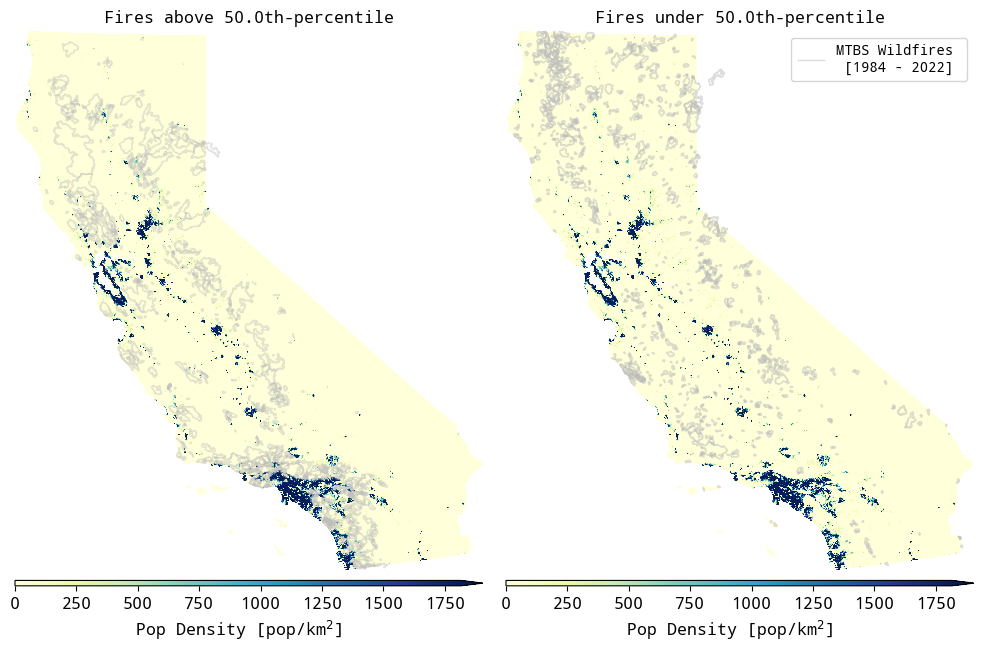

In [13]:
############################# PREPARE DATA FOR PLOT ############################
ds = rioxarray.open_rasterio(pop_dict[2020]).squeeze()

with xr.set_options(keep_attrs=True):
    clip_box = ds.rio.clip_box(*ca.total_bounds)
    cal_pop = clip_box.rio.clip(
        ca.geometry.values, ca.crs, drop=True, invert=False
    ).rio.reproject_match(template)

    cal_pop = xr.where(cal_pop == ds.attrs["_FillValue"], np.nan, cal_pop)
################################################################################


fig, ax = plt.subplots(1, 2, figsize=(10, 12))

thresh_def = 0.50

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

cal_pop.plot(
    robust=True,
    ax=ax[0],
    cbar_ax=cax,
    cmap="YlGnBu",
    cbar_kwargs={"label": r"Pop Density [pop/km$^2$]", "orientation": "horizontal"},
)

tresh = pop_dens.total_pop.quantile([thresh_def]).values[0]
subset_events = pop_dens[pop_dens.total_pop >= tresh]

subset_events.geometry.boundary.plot(ax=ax[0], color="#bdbdbd", linewidth=1, alpha=0.4)

template_plots(ax[0], no_axis=True, ylab="", xlab="")

ax[0].set_title(f"Fires above {thresh_def * 100}th-percentile", fontsize=12)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

# Low density
cal_pop.plot(
    robust=True,
    ax=ax[1],
    cbar_ax=cax,
    cmap="YlGnBu",
    cbar_kwargs={"label": r"Pop Density [pop/km$^2$]", "orientation": "horizontal"},
)

tresh = pop_dens.total_pop.quantile([thresh_def]).values[0]
subset_events = pop_dens[pop_dens.total_pop <= tresh]

subset_events.geometry.boundary.plot(
    ax=ax[1],
    color="#bdbdbd",
    linewidth=1,
    alpha=0.5,
    label="MTBS Wildfires \n [1984 - 2022]",
)
ax[1].legend(loc="upper right", fontsize=10)

template_plots(ax[1], no_axis=True, ylab="", xlab="")

ax[1].set_title(f"Fires under {thresh_def * 100}th-percentile", fontsize=12)

# Save plot
plt.tight_layout()
#plt.savefig("../figs/pop_density_fires.png", dpi=300)

In [25]:
test_dist = create_distances(mtbs_shapefile=mtbs_ca, template=template, pop_raster_path="/mnt/sherlock/oak/prescribed_data/raw/population", mask=ca)

test_dist = test_dist.merge(land_type.drop(columns=["lat", "lon"]), on="grid_id")

Calculating population density...: 100%|██████████| 1886/1886 [00:44<00:00, 42.17it/s]


In [61]:
test_dist[(~test_dist.distance.isna()) & (test_dist.treatment != "nodata")]

,lat,lon,wildfire,treatment,distance,all,year,grid_id,land_type
2050,448152.596997,-317913.82085,nodata,CA4185812335420200908,-0.000000,CA4185812335420200908,2020,1888.0,2.0
2088,448152.596997,-316913.82085,nodata,CA4185812335420200908,-1000.000000,CA4185812335420200908,2020,1889.0,2.0
2126,448152.596997,-315913.82085,nodata,CA4185812335420200908,-2000.000000,CA4185812335420200908,2020,1890.0,2.0
2164,448152.596997,-314913.82085,nodata,CA4185812335420200908,-2828.427246,CA4185812335420200908,2020,1891.0,2.0
2202,448152.596997,-313913.82085,nodata,CA4185812335420200908,-3605.551270,CA4185812335420200908,2020,1892.0,2.0
...,...,...,...,...,...,...,...,...,...
15450273,-578847.403003,340086.17915,nodata,CA3281011635519890621,-4000.000000,CA3285711638619890709,1989,943278.0,12.0
15450311,-578847.403003,341086.17915,nodata,CA3281011635519890621,-4123.105469,CA3285711638619890709,1989,943279.0,5.0
15450349,-578847.403003,342086.17915,nodata,CA3281011635519890621,-4472.135742,CA3285711638619890709,1989,943280.0,12.0
15450387,-578847.403003,343086.17915,nodata,CA3281011635519890621,-5000.000000,CA3285711638619890709,1989,943281.0,12.0


<Axes: xlabel='lon', ylabel='lat'>

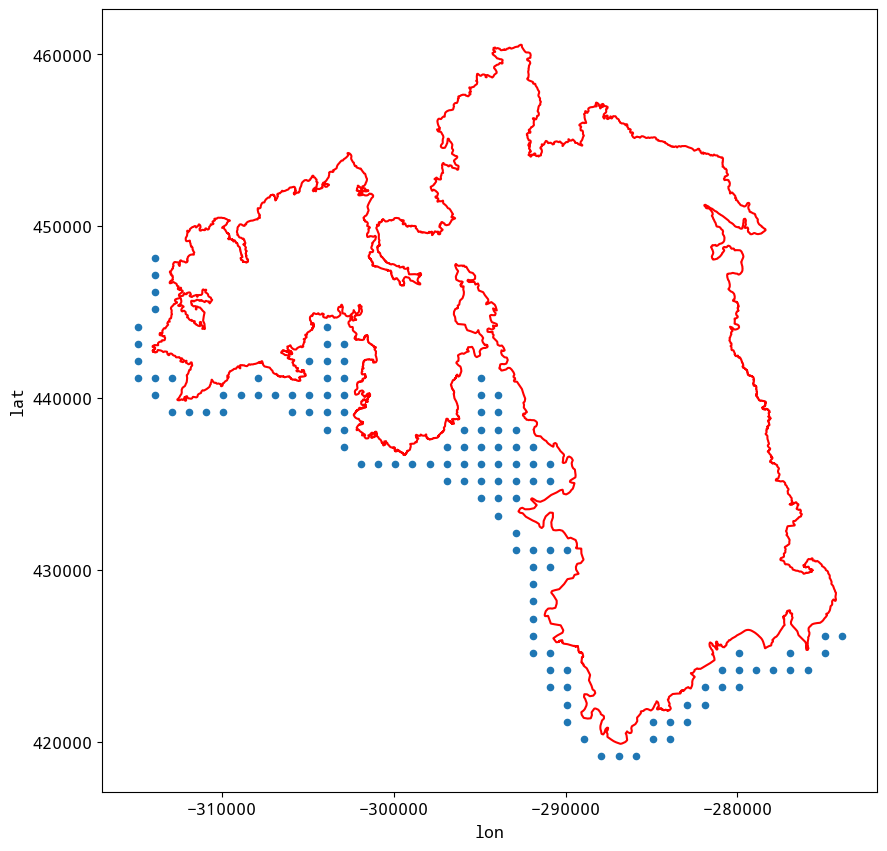

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
test_dist[(test_dist.treatment == "CA4185812335420200908") & (np.abs(test_dist["distance"]) > 3000)].plot.scatter(x='lon', y='lat', ax=ax)
mtbs_ca[mtbs_ca.Event_ID == "CA4185812335420200908"].boundary.plot(ax=ax, color='red') 

<Axes: xlabel='lon', ylabel='lat'>

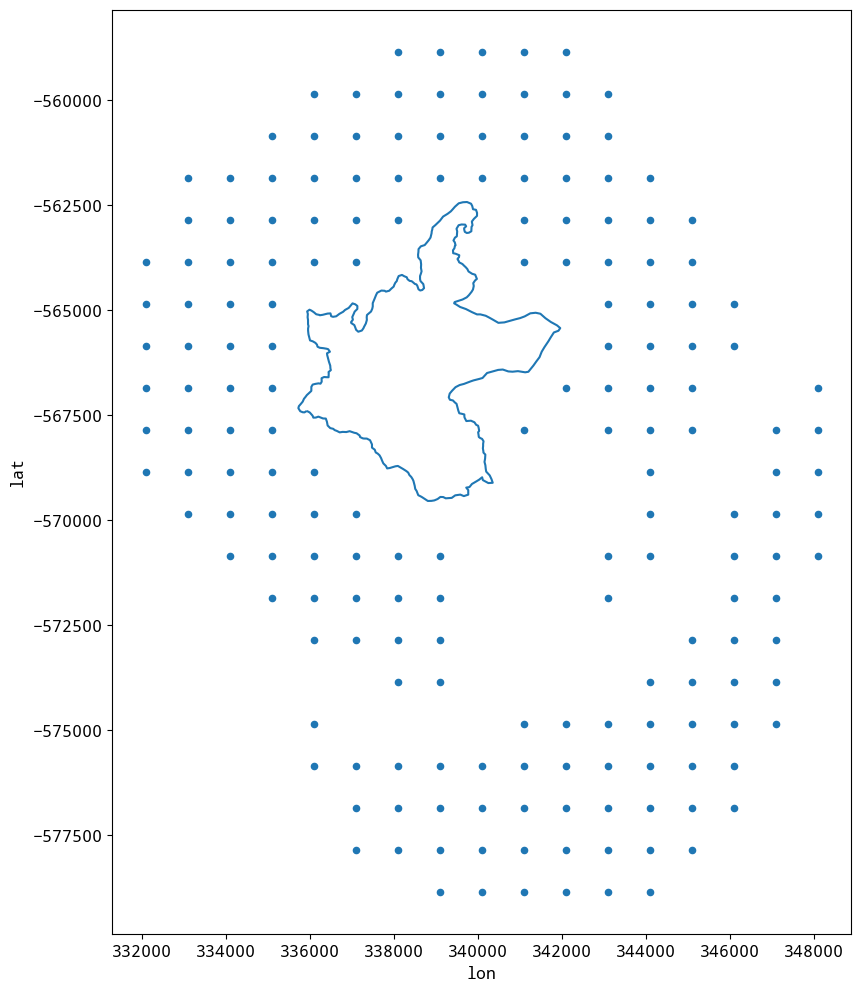

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
test_dist[(test_dist["all"] == "CA3285711638619890709")  & (test_dist.distance < 0)].plot.scatter(x="lon", y="lat", ax=ax)
mtbs_ca[mtbs_ca.Event_ID == "CA3285711638619890709"].boundary.plot(ax=ax)

<Axes: xlabel='lon', ylabel='lat'>

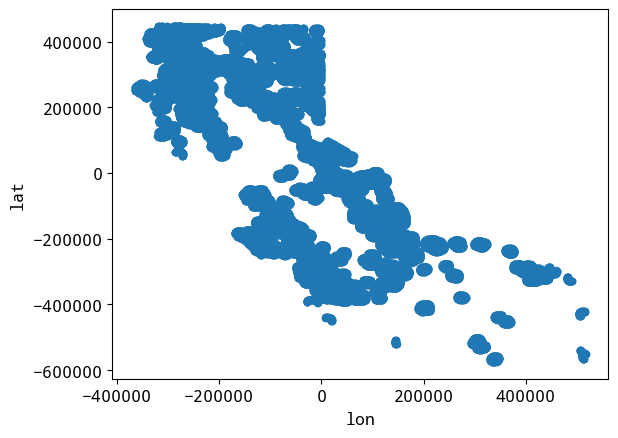

In [32]:
test_dist[(~test_dist.distance.isna()) & (test_dist.distance < 2000) & (test_dist.distance >= 0)].plot.scatter(x="lon", y="lat")

<Axes: >

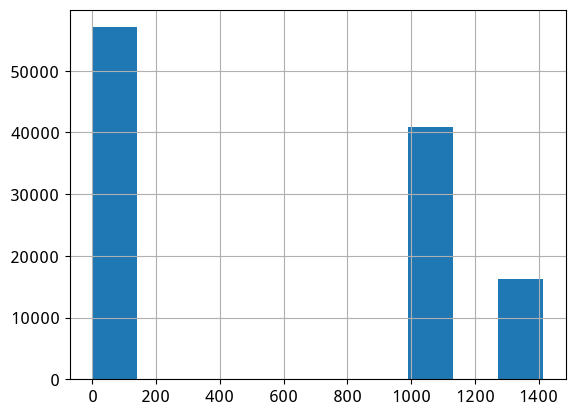

In [31]:
test_dist[(~test_dist.distance.isna()) & (test_dist.distance < 2000) & (test_dist.distance >= 0)].distance.hist()